<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset el mismo dataset creado para el TP de la clase 3

In [2]:
# import "sinceramente_sentences.txt" as a list of sentences
with open('../Clase 3/sinceramente_sentences.txt', 'r') as f:
    sentences = f.read().split('\n')


### Preprocesamiento

In [3]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4
df = pd.DataFrame(sentences, columns=['sentences'])

# Creo los tokens para todo el corpus
corpus = ' '.join(sentences)
tokens=text_to_word_sequence(corpus)

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [4]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [5]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [15]:
tok = Tokenizer() 

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado, esta sutileza nos dará un pequeño
# problema al momento de hacer la codificación OHE, pero es sencillo de resolver
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)
vocab_size = len(tok.word_counts)
print(f'Head de sequences: {sequences[0:5]}')
# print(f'Palabras del vocabulario: {tok.index_word}')
print(f'Cantidad de secuencias: {len(text_sequences)}')
print(f'Cantidad de palabras: {vocab_size}')



Head de sequences: [[4038, 1683, 5, 319], [1683, 5, 319, 515], [5, 319, 515, 1], [319, 515, 1, 91], [515, 1, 91, 563]]
Cantidad de secuencias: 156904
Cantidad de palabras: 17415


In [8]:
print(f'Palabras del vocabulario: {tok.index_word}')


Palabras del vocabulario: {1: 'de', 2: 'que', 3: 'la', 4: 'y', 5: 'el', 6: 'en', 7: 'a', 8: 'los', 9: 'no', 10: 'del', 11: 'por', 12: 'con', 13: 'un', 14: 'se', 15: 'las', 16: 'una', 17: 'lo', 18: 'para', 19: 'me', 20: 'como', 21: 'había', 22: 'es', 23: 'al', 24: 'más', 25: 'su', 26: 'era', 27: 'fue', 28: 'le', 29: 'cuando', 30: 'ese', 31: 'néstor', 32: 'mi', 33: 'o', 34: 'gobierno', 35: 'porque', 36: 'pero', 37: 'también', 38: 'argentina', 39: 'muy', 40: 'todo', 41: 'estaba', 42: 'sin', 43: 'durante', 44: 'esa', 45: 'sus', 46: 'nos', 47: 'sobre', 48: 'si', 49: 'país', 50: 'todos', 51: 'yo', 52: 'después', 53: 'ser', 54: 'nuestro', 55: 'años', 56: 'ya', 57: 'eso', 58: 'sólo', 59: 'vez', 60: 'él', 61: 'ni', 62: 'habían', 63: 'año', 64: 'nunca', 65: 'siempre', 66: 'dos', 67: 'desde', 68: 'sino', 69: 'entre', 70: 'poder', 71: 'presidente', 72: 'día', 73: 'sido', 74: 'estado', 75: 'tenía', 76: 'ley', 77: 'contra', 78: 'así', 79: 'qué', 80: 'argentinos', 81: 'hasta', 82: 'medios', 83: 'mism

### 3 - Input y target

In [7]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(156904, 3)
(156904,)


In [8]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size+1)

In [9]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(156904, 17415)

### 4 - Entrenar el modelo

In [10]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
# Largo del vector de salida --> vocab_size
output_size = vocab_size

In [25]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128)) # La última capa LSTM no lleva return_sequences
model.add(Dense(64, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 3, 5)              87080     
                                                                 
 lstm_6 (LSTM)               (None, 3, 64)             17920     
                                                                 
 dropout_3 (Dropout)         (None, 3, 64)             0         
                                                                 
 lstm_7 (LSTM)               (None, 128)               98816     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 17415)             1131975   
                                                                 
Total params: 1,344,047
Trainable params: 1,344,047
No

In [26]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
3923/3923 [==============================] - 34s 8ms/step - loss: 7.0750 - accuracy: 0.0632 - val_loss: 6.9802 - val_accuracy: 0.0763
Epoch 2/50
3923/3923 [==============================] - 31s 8ms/step - loss: 6.5911 - accuracy: 0.0833 - val_loss: 6.9717 - val_accuracy: 0.0941
Epoch 3/50
3923/3923 [==============================] - 30s 8ms/step - loss: 6.2753 - accuracy: 0.0971 - val_loss: 7.0644 - val_accuracy: 0.1005
Epoch 4/50
3923/3923 [==============================] - 30s 8ms/step - loss: 6.0245 - accuracy: 0.1113 - val_loss: 7.0922 - val_accuracy: 0.1119
Epoch 5/50
3923/3923 [==============================] - 31s 8ms/step - loss: 5.8153 - accuracy: 0.1219 - val_loss: 7.1180 - val_accuracy: 0.1115
Epoch 6/50
3923/3923 [==============================] - 31s 8ms/step - loss: 5.6206 - accuracy: 0.1307 - val_loss: 7.1213 - val_accuracy: 0.1166
Epoch 7/50
3923/3923 [==============================] - 31s 8ms/step - loss: 5.4400 - accuracy: 0.1384 - val_loss: 7.1851 - val_ac

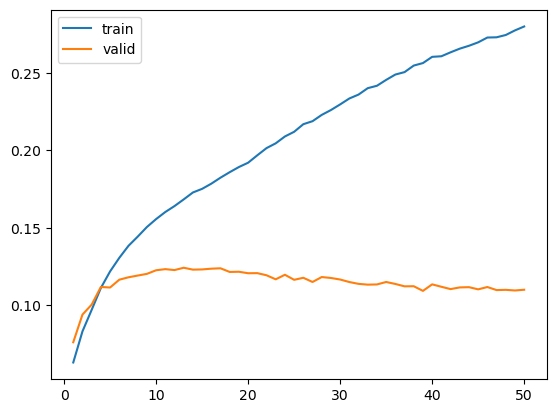

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [34]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [22]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [28]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/Users/marcosb/opt/miniconda3/envs/nlp_tensor/lib/python3.10/site-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 15ms/step
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [29]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [33]:
input_text='los medios estan'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

1/1 [==============================] - 0s 12ms/step


'los medios estan  '

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.